## Домашнее задание № 5: Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

In [1]:
#!pip install fake_useragent

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm_notebook

In [2]:
# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent

In [3]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'

## Описание задачи

Парсинг сайта https://topliba.com/ с целью сбора данных о книгах (рейтинг, название, описание, год выпуска) по жанру Фэнтези. Дело в том, что большинство современных книжный сайтов не предоставляют возможности делать сквозной  поиск по всем страницам, а только в рамках жанровых категорий. Наиболее представленный жанр н данном сайте - фэнтези (783 страницы поиска) по нему и будем делать парсинг. На данном сайте список фильмов подгружается динамически по страницам. Обратимся к странице Фэнтези, и запишем запрос к данной странице.

In [4]:
page_link = 'https://topliba.com/genres/12090?p=1'

In [5]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [6]:
html = response.content

### Получение ссылок с фильмами

С помощью библиотеки BeautifulSoup распарсим страницу и найдем ссылки книгам. 

In [7]:
soup = BeautifulSoup(response.content, 'html.parser')

In [8]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
html = response.content
html[:1000]

b'<!DOCTYPE html>\n<html lang="ru">\n    <head>\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n        <meta name="viewport" content="width=device-width, initial-scale=1">\n        <title>\xd0\xa4\xd1\x8d\xd0\xbd\xd1\x82\xd0\xb5\xd0\xb7\xd0\xb8: \xd1\x81\xd0\xba\xd0\xb0\xd1\x87\xd0\xb0\xd1\x82\xd1\x8c \xd0\xba\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb8 \xd0\xb2 fb2, \xd1\x87\xd0\xb8\xd1\x82\xd0\xb0\xd1\x82\xd1\x8c \xd0\xbe\xd0\xbd\xd0\xbb\xd0\xb0\xd0\xb9\xd0\xbd \xe2\x80\xa2 \xd0\xa1\xd1\x82\xd1\x80\xd0\xb0\xd0\xbd\xd0\xb8\xd1\x86\xd0\xb0 1</title>\n        <meta name="description" content="\xd0\x9a\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb8 \xd0\xb6\xd0\xb0\xd0\xbd\xd1\x80\xd0\xb0 \xd0\xa4\xd1\x8d\xd0\xbd\xd1\x82\xd0\xb5\xd0\xb7\xd0\xb8 \xd0\xb4\xd0\xbe\xd1\x81\xd1\x82\xd1\x83\xd0\xbf\xd0\xbd\xd1\x8b\xd0\xb5 \xd0\xb2 \xd1\x84\xd0\xbe\xd1\x80\xd0\xbc\xd0\xb0\xd1\x82\xd0\xb5 fb2, \xd0\xb0 \xd1\x82\xd0\xb0\xd0\xba\xd0\xb6\xd0\xb5 \xd0\xb4\xd0\xbb\xd1\x8f \xd1\x

In [9]:
book_container = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])
book_container[:6]

[<a class="book-title" href="https://topliba.com/books/901392" title="Скачать книгу Куратор Тёмного факультета">Куратор Тёмного факультета</a>,
 <a class="book-title" href="https://topliba.com/books/901363" title="Скачать книгу Сбежавшая невеста (от) для дракона">Сбежавшая невеста (от) для дракона</a>,
 <a class="book-title" href="https://topliba.com/books/901288" title="Скачать книгу Прототип 2.0 | Часть II">Прототип 2.0 | Часть II</a>,
 <a class="book-title" href="https://topliba.com/books/901278" title="Скачать книгу Последний попаданец 9">Последний попаданец 9</a>,
 <a class="book-title" href="https://topliba.com/books/901050" title="Скачать книгу Сказочная ложь">Сказочная ложь</a>,
 <a class="book-title" href="https://topliba.com/books/901045" title="Скачать книгу Мелодия воспоминаний">Мелодия воспоминаний</a>]

In [10]:
# Cписок ссылок на каждую книгу со страницы
book_links = [link.attrs['href'] for link in 
                  soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])]
book_links[:6]

['https://topliba.com/books/901392',
 'https://topliba.com/books/901363',
 'https://topliba.com/books/901288',
 'https://topliba.com/books/901278',
 'https://topliba.com/books/901050',
 'https://topliba.com/books/901045']

На сайте https://topliba.com/ book_links уже выводятся полностью, вместе с названием сайта, поэтому вместо ['https://topliba.com' + link.attrs['href'] for link in book_links] будем подставлять только ['link.attrs['href'] for link in book_links]

In [11]:
def getPageLinks(page_number): # функция для вытаскивания ссылок на конкретные книги,
                               # возвращает список из ссылок на книги, полученные с текущей страницы  
                               # Параметры: page_number: int/string - номер страницы для парсинга            
    
    # составляем ссылку на страницу поиска
    page_link = 'https://topliba.com/genres/12090?p={}'.format(page_number)
    
    # запрашиваем данные о ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
        
    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        print('Сервер ничего не вернул')
        return [] 
    
    # получаем содержимое страницы и переводим в суп
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # ищем ссылки на книги и формируем полные ссылки
    meme_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['photo'])
    meme_links = ['http://knowyourmeme.com' + link.attrs['href'] for link in meme_links]
    
    book_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])
    book_links = [link.attrs['href'] for link in book_links]
    
    return book_links

In [12]:
# book_links = getPageLinks(30)
# book_links

### Получим информации о книге
Обратимся к странице с фильмом Сердце Дракона. Том 2 и достанем следующую информацию:
- Название книги.
- Автор книги
- Оценка книги
- Аннотация/Описание
- Количество читателей
- Количество комментариев/отзывов

In [13]:
book_page = 'https://topliba.com/books/736796'
response = requests.get(book_page, headers={'User-Agent': UserAgent().chrome})

html = response.content
soup = BeautifulSoup(response.content, 'html.parser')

### Получим название книги

In [14]:
book_title = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['row'])
book_title

<div class="row">
<div class="header-background"><div style="background: url(https://topliba.com/covers/736796.jpg?t=1705317373)"></div></div>
<div class="col-xs-12 col-sm-3 cover">
<div itemscope="" itemtype="http://schema.org/ImageObject" style="position: relative">
<meta content="Лисина Александра - Щит императора" itemprop="name">
<img alt="Лисина Александра - Щит императора" itemprop="contentUrl" src="https://topliba.com/covers/736796.jpg?t=1705317373" title="Лисина Александра - Щит императора"/>
</meta></div>
</div>
<div class="col-xs-12 col-sm-9 book-title">
<h1 itemprop="name">Щит императора</h1>
<h2 class="book-author" itemprop="author">
<a href="https://topliba.com/authors/2142" title="Книги Александра Лисина">Александра Лисина</a>
</h2>
</div>
</div>

Заголовок книги находится в теге h1, который имеет атрибут itemprop="name". 

In [15]:
book_title = soup.find('h1', itemprop='name').text
book_title

'Щит императора'

In [16]:
#book_title = soup.find(lambda tag: tag.name == 'h1') # and tag.get('itemprop') == ['name'])
#book_title = film_title.text
#book_title

### Получим автора книги

In [17]:
book_author = soup.find(lambda tag: tag.name == 'h2' and tag.get('class') == ['book-author'])
book_author = book_author.text.replace("\n", "")
book_author

'Александра Лисина'

### Получим аннотацию к книге

In [18]:
book_announs = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['description']).text
book_announs = book_announs.strip()
book_announs

'После смерти великого императора Орриана на престол вступает его единственный сын, которому в наследство достается не только страна, но и телохранитель. Карриану не нужен такой довесок к короне, однако нарушить волю отца он не рискует. Мару тоже не нравится это решение, но приказ хозяина для него превыше собственных предпочтений. Для двух врагов подобное соседство — худшее, что только можно измыслить. Тень, не желающая оберегать нового императора, и император, ненавидящий свою тень… Казалось бы, у этих двоих нет и не может быть ничего общего. Но жизнь все расставляет по своим местам.'

### Получим рейтинг книги 

Рейтинги книг хранятся в аттрибутах тега div class="col-lg-12". Посмотрим на структуру данного тега.

In [19]:
scoreboard = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['col-lg-12'])
scoreboard

<div class="col-lg-12">
<rating _avgrating="4.75" _rating="0" _ratingsnumber="251" _showavgrating="true" _showavgratingtext="true" _url="/books/736796/ratings" _user="" class="pull-left"></rating>
<meta content="1" itemprop="worstRating"/>
<meta content="5" itemprop="bestRating"/>
<meta content="251" itemprop="ratingCount"/>
<meta content="4.75" itemprop="ratingValue"/>
</div>

In [20]:
def getRating(soup, rate):
    try:
        obj = soup.find('rating', attrs={'class':'pull-left'})
        obj = obj.get(rate)
    except:
        obj=None
    
    return obj

In [21]:
getRating(soup, '_avgrating')

'4.75'

### Получим количество читателей книги и количества комментариев (отзывов)

Сведения о читателях хранятся в book-readers

In [22]:
book_readers = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['book-readers'])
book_readers

<div class="book-readers">
<div class="col-lg-8 col-sm-12 well-sm">
<div class="col-sm-2 col-xs-4 book-readers-status">
<span class="book-readers-status-count">496</span>
<span>читателей</span>
</div>
<div class="col-sm-2 col-xs-4 book-readers-status">
<a href="https://topliba.com/books/736796/impressions">
<span class="book-readers-status-count">88</span>
<span>отзывов</span>
</a>
</div>
<div class="col-sm-2 col-xs-4 book-readers-status">
<a href="https://topliba.com/books/736796/quotes">
<span class="book-readers-status-count">20</span>
<span>цитат</span>
</a>
</div>
</div>
</div>

In [23]:
# Находим все span элементы с классом 'book-readers-status-count'
readers_count_elements = soup.find_all('span', class_='book-readers-status-count')

book_readership_count = readers_count_elements[0].string  
book_comment_count = readers_count_elements[1].string  

print("Количество читателей:", book_readership_count)
print("Количество отзывов:", book_comment_count)

Количество читателей: 496
Количество отзывов: 88


### Получение данных о жанре и годе издания

In [24]:
# Находим все теги div с классом 'col-lg-12'
# search_elements = soup.find_all('div', class_='col-lg-12')
# search_elements

In [25]:
"""
genre = search_elements[1].text.replace('\n', '')  
year = search_elements[2].text.replace('\n', '')

print("Жанры:", genre)
print("Год:", year)
"""

'\ngenre = search_elements[1].text.replace(\'\n\', \'\')  \nyear = search_elements[2].text.replace(\'\n\', \'\')\n\nprint("Жанры:", genre)\nprint("Год:", year)\n'

## Получение информации по всем книгам

### Страница https://topliba.com/genres/12090?p=784 дает ссылки на 784 страницах, на каждой странице по 24 ссылки на книгу. Итого будет 18 816 ссылок на книги

In [26]:
def getBookData(book_page):
    # запрашиваем данные по ссылке
    response = requests.get(book_page, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем статус ошибки
        return response.status_code

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # используя ранее написанные функции парсим информацию
    book_title = soup.find('h1', itemprop='name').text
                 
    book_author = soup.find(lambda tag: tag.name == 'h2' and tag.get('class') == ['book-author'])
    book_author = book_author.text.replace("\n", "")
    
    book_announs = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['description']).text
    book_announs = book_announs.replace('\n', '')
    book_announs = book_announs.strip()
         
    raiting = getRating(soup=soup, rate='_avgrating')
    
    readers_count_elements = soup.find_all('span', class_='book-readers-status-count')

    book_readership_count = readers_count_elements[0].string  
        
    book_comment_count = readers_count_elements[1].string  
           
    # составляем словарь, в котором будут хранится все полученные и обработанные данные
    data_row = {'Title':book_title, 'Author':book_author,
                'Description':book_announs, 'Raiting':raiting, 'Readers':book_readership_count,'Comments':book_comment_count}
    return data_row

In [27]:
data_row = getBookData('https://topliba.com/books/736796')

In [28]:
data_row

{'Title': 'Щит императора',
 'Author': 'Александра Лисина',
 'Description': 'После смерти великого императора Орриана на престол вступает его единственный сын, которому в наследство достается не только страна, но и телохранитель. Карриану не нужен такой довесок к короне, однако нарушить волю отца он не рискует. Мару тоже не нравится это решение, но приказ хозяина для него превыше собственных предпочтений. Для двух врагов подобное соседство — худшее, что только можно измыслить. Тень, не желающая оберегать нового императора, и император, ненавидящий свою тень… Казалось бы, у этих двоих нет и не может быть ничего общего. Но жизнь все расставляет по своим местам.',
 'Raiting': '4.75',
 'Readers': '496',
 'Comments': '88'}

In [29]:
"""
import time
from tqdm.notebook import tqdm

lst = []
for i in tqdm(range(700)):
    links = getPageLinks(i)
    time.sleep(0.5)
    for j in links:
        try:
            book_data = getBookData(j)
            lst.append(book_data)
            time.sleep(0.5)
        except Exception as e:
            print(e, i, j)

df = pd.DataFrame(lst).drop_duplicates(subset=['Title'])
df.to_csv('books_full.csv', index=False)
"""

"\nimport time\nfrom tqdm.notebook import tqdm\n\nlst = []\nfor i in tqdm(range(700)):\n    links = getPageLinks(i)\n    time.sleep(0.5)\n    for j in links:\n        try:\n            book_data = getBookData(j)\n            lst.append(book_data)\n            time.sleep(0.5)\n        except Exception as e:\n            print(e, i, j)\n\ndf = pd.DataFrame(lst).drop_duplicates(subset=['Title'])\ndf.to_csv('books_full.csv', index=False)\n"

In [30]:
data = pd.read_csv('books_full.csv')
data.head()

,Title,Author,Description,Raiting,Readers,Comments
0,Я - воин,Анастасия Сиалана,Я воин! Воин первой руки великой Зиреи. Я маг ...,3.17,13,0
1,Девятый уровень. Часть вторая,Дмитрий Серебряков,"То, что казалось нереальным в начале пути, теп...",4.33,5,0
2,Одна посылка в квартал Длинных плащей,Сергей Янин,Кальвин всегда мечтал познакомиться с магом. О...,NaN,2,0
3,"Демон в беде, или Как избавиться от ведьмы?","Иринья Коняева, Татьяна Серганова","Меня, ведьму, и замуж против воли? Не дождетес...",3.42,355,17
4,Вагон второго класса. Том I,"Элина Литера, Анна Литера",Юная леди Илона Горналон — любимая дочь состоя...,3.75,13,0


# Часть 2. NLP

In [31]:
# вычисляем долю пропущенных значений для каждого столбца в DataFrame
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

Raiting    0.26
dtype: float64

In [32]:
data.dropna().shape[0] / data.shape[0]

0.7362807713771935

In [33]:
data.dropna(inplace=True)

In [34]:
data.isnull().sum()

Title          0
Author         0
Description    0
Raiting        0
Readers        0
Comments       0
dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11874 entries, 0 to 16124
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        11874 non-null  object 
 1   Author       11874 non-null  object 
 2   Description  11874 non-null  object 
 3   Raiting      11874 non-null  float64
 4   Readers      11874 non-null  int64  
 5   Comments     11874 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 649.4+ KB


## 1.2. Базовые статистики датасета

**Распределение числовых признаков**

In [36]:
data.describe().round(2)

,Raiting,Readers,Comments
count,11874.00,11874.00,11874.00
mean,3.97,48.98,5.05
std,1.02,125.09,16.13
min,0.00,0.00,0.00
25%,3.76,3.00,0.00
50%,4.11,8.00,0.00
75%,4.50,31.00,2.00
max,5.00,2184.00,326.00


array([[<Axes: title={'center': 'Raiting'}>,
        <Axes: title={'center': 'Readers'}>],
       [<Axes: title={'center': 'Comments'}>, <Axes: >]], dtype=object)

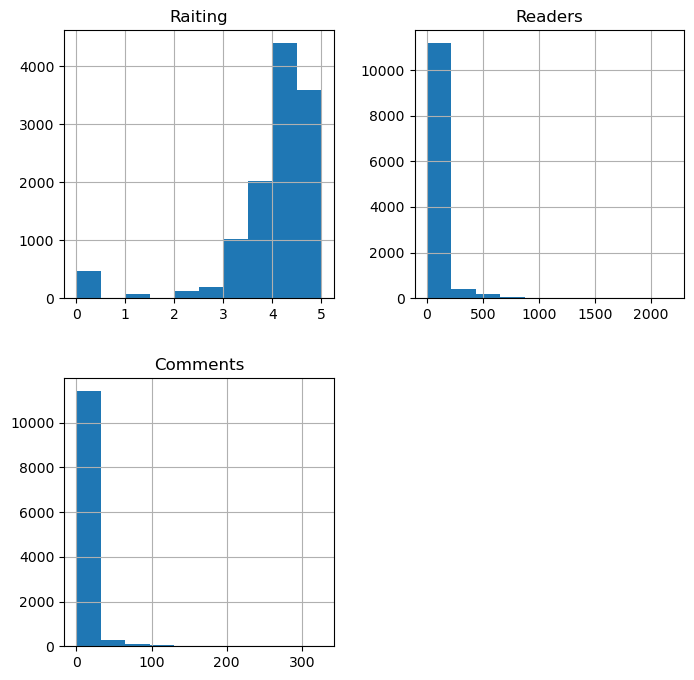

In [37]:
data.hist(figsize=(8, 8))

Для большинства книг количество читателей и комментариев либо нет, либо их мало. 
А вот оценок гораздо больше. 

Как известно, название, играет одно из ключевых факторов, для привлечения внимания к книге.
Попробуем по текстовому заголовка книги построить модель зависимости интереса пользователей (оценку читателей) от ее названия. Выявим, какие слова в названии являются ключевыми для привлечения внимания читателей. Сможем ли мы по названию предсказать оценку?

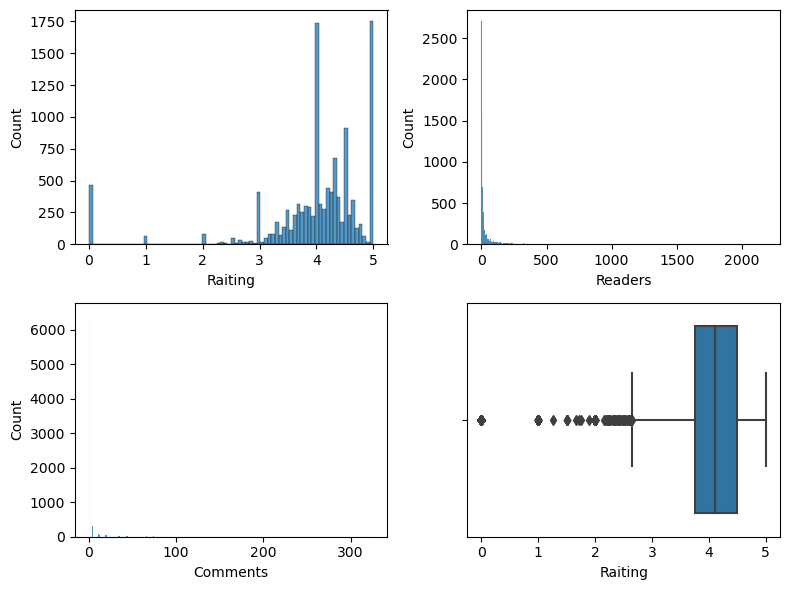

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.histplot(data=data, x="Raiting", multiple="dodge", ax=axes[0, 0])

sns.histplot(data=data, x="Readers", multiple="dodge", ax=axes[0, 1])

sns.histplot(data=data, x="Comments", multiple="dodge", ax=axes[1, 0])

# Построение графика boxplot для столбца "Raiting"
sns.boxplot(x=data["Raiting"], ax=axes[1, 1])

plt.tight_layout()
plt.show()

Из графика видно, что средняя оценка 4.

## Подготовим текст к обработке. Применим лемматизацию и отсеим стоп-слова.
Скачаем пакет с русскими стоп-словами.

### Токенизация и удаление стоп слов

In [39]:
import nltk   # Natural Language Toolkit

In [40]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:20])

151
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Я хочу попробовать использовать два метода обработки текста: 1) mystem из pymystem3 и 2) библиотеку nltk и pymorphy2 и сравнить их производительность и точность.

# Первый способ  - обработка текста с помощью mystem из pymystem3

In [41]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
!pip install pymystem3

In [43]:
from nltk.corpus import stopwords
from string import punctuation
from pymystem3 import Mystem

mystem = Mystem() 
stop_words = stopwords.words("russian")

**Создадим функцию, которая будет осуществлять предобработку текста**

In [44]:
def lemmatize_and_filter(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words \
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

Проверим работу функции на одной строке

In [45]:
data['Title'].values[0]

'Я - воин'

In [46]:
lemmatize_and_filter(data['Title'].values[0])

'воин'

Предобработка для всего датасета

In [47]:
"""
from tqdm import tqdm
tqdm.pandas()

def process_text(text):
    return lemmatize_and_filter(text)

data_preprocessed = data.copy()
data_preprocessed['Title'] = data['Title'].progress_apply(process_text)

# Сохранение предобработанных данных
data_preprocessed.to_csv('preprocessed_data.csv', index=False)
"""

"\nfrom tqdm import tqdm\ntqdm.pandas()\n\ndef process_text(text):\n    return lemmatize_and_filter(text)\n\ndata_preprocessed = data.copy()\ndata_preprocessed['Title'] = data['Title'].progress_apply(process_text)\n\n# Сохранение предобработанных данных\ndata_preprocessed.to_csv('preprocessed_data.csv', index=False)\n"

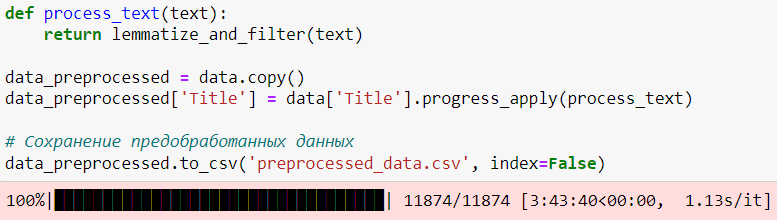

In [48]:
# Загрузка из предобработанных данных
preprocessed_data = pd.read_csv('preprocessed_data.csv')

In [49]:
preprocessed_data.dropna(inplace=True)

In [50]:
preprocessed_data.isnull().sum()

Title          0
Author         0
Description    0
Raiting        0
Readers        0
Comments       0
dtype: int64

In [51]:
preprocessed_data['Title'].values[100]

'жемчужный узел'

Сохраним в Х - признак, а в у - целевую переменную.

In [52]:
X = preprocessed_data['Title']
y = preprocessed_data['Raiting']

In [53]:
X.shape, y.shape

((11864,), (11864,))

Разобьем выборку на train/test

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8304,), (3560,), (8304,), (3560,))

In [55]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_df=0.7, min_df=5,
                              max_features=2987,
                              stop_words='english',
                              ngram_range=(1,2),
                              norm=None)

tfidf = tfidf_model.fit_transform(X_train).todense()
tfidf

CPU times: total: 188 ms
Wall time: 177 ms


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
tfidf_model.vocabulary_

{'дикий': 202,
 'опасный': 508,
 'бог': 56,
 'орден': 510,
 'крест': 377,
 'пламень': 551,
 'война': 116,
 'темный': 767,
 'отбор': 518,
 'верность': 88,
 'слуга': 709,
 'пленник': 554,
 'власть': 108,
 'сила': 696,
 'загадка': 254,
 'си': 695,
 'магический': 418,
 'посох': 587,
 'седьмой': 684,
 'мир': 439,
 'ведьмин': 81,
 'наследство': 462,
 'хозяйка': 821,
 'серый': 693,
 'земля': 275,
 'человек': 851,
 'огненный': 498,
 'буря': 73,
 'счастие': 755,
 'ведьма': 79,
 'самый': 670,
 'вид': 100,
 'тьма': 787,
 'книга': 335,
 'тьма книга': 788,
 'правило': 594,
 'сердце': 688,
 'тварь': 763,
 'маленький': 423,
 'голубой': 174,
 'выживать': 152,
 'эльф': 881,
 'фэнтези': 816,
 'ладонь': 386,
 'хаос': 817,
 'выбор': 149,
 'судьба': 750,
 'сон': 725,
 'черный': 853,
 'путешествие': 637,
 'страна': 740,
 'свет': 674,
 'ученица': 806,
 'звездный': 271,
 'дракон': 223,
 'мастер': 426,
 'зверь': 272,
 'тень': 771,
 'капитан': 325,
 'пылать': 639,
 'север': 682,
 'император': 306,
 'берег': 50,

In [57]:
train_data = pd.DataFrame(
    tfidf_model.fit_transform(X_train).todense(),
    columns=tfidf_model.get_feature_names_out()
)
train_data

,10,11,12,13,14,18,ii,iii,online,warcraft,...,эпоха,эрагон,это,эхо,южный,яга,яд,янтарный,ярость,ястреб
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
test_data = pd.DataFrame(
    tfidf_model.transform(X_test).todense(),
    columns=tfidf_model.get_feature_names_out()
)
test_data

,10,11,12,13,14,18,ii,iii,online,warcraft,...,эпоха,эрагон,это,эхо,южный,яга,яд,янтарный,ярость,ястреб
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Построение модели регрессии

Целевая переменная непрерывная  - оценка или число читателей, поэтому строим линейную регрессию.

In [59]:
from sklearn import metrics

metrics_table = pd.DataFrame({"error_type":["MAE", "MSE", "R2"]})
metrics_table.set_index("error_type")

""
error_type
MAE
MSE
R2


In [60]:
%%time

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=Lasso(), 
                         param_grid={'alpha': np.arange(0.01, 10, 0.1)}, 
                         scoring='r2',                          
                         n_jobs=-1)
grid_search.fit(train_data, y_train)

print('Best Score: ', grid_search.best_score_)
print('Best Params: ', grid_search.best_params_)

y_pred = grid_search.predict(test_data)
regressor = grid_search.best_estimator_

metrics_table['Regressor'] = [
    metrics.mean_absolute_error(y_test, y_pred),
    metrics.mean_squared_error(y_test, y_pred),
    metrics.r2_score(y_test, y_pred)
]

metrics_table

Best Score:  0.008659095423247632
Best Params:  {'alpha': 0.01}
CPU times: total: 3.56 s
Wall time: 39.6 s


,error_type,Regressor
0,MAE,0.635526
1,MSE,1.031066
2,R2,0.016809


**Построим график важности признаков топ-50 слов**

In [61]:
non_zero_coef_indices = np.where(regressor.coef_ != 0)[0]
words = train_data.columns[non_zero_coef_indices][:50]
words

Index(['вампир', 'ветер', 'воин', 'гамбит', 'герой', 'глаз', 'гора', 'ключ',
       'книга', 'компиляция', 'король', 'корона', 'лп', 'маг', 'мир', 'путь',
       'роман', 'сборник', 'си', 'стихия', 'темный', 'трилогия', 'человек'],
      dtype='object')

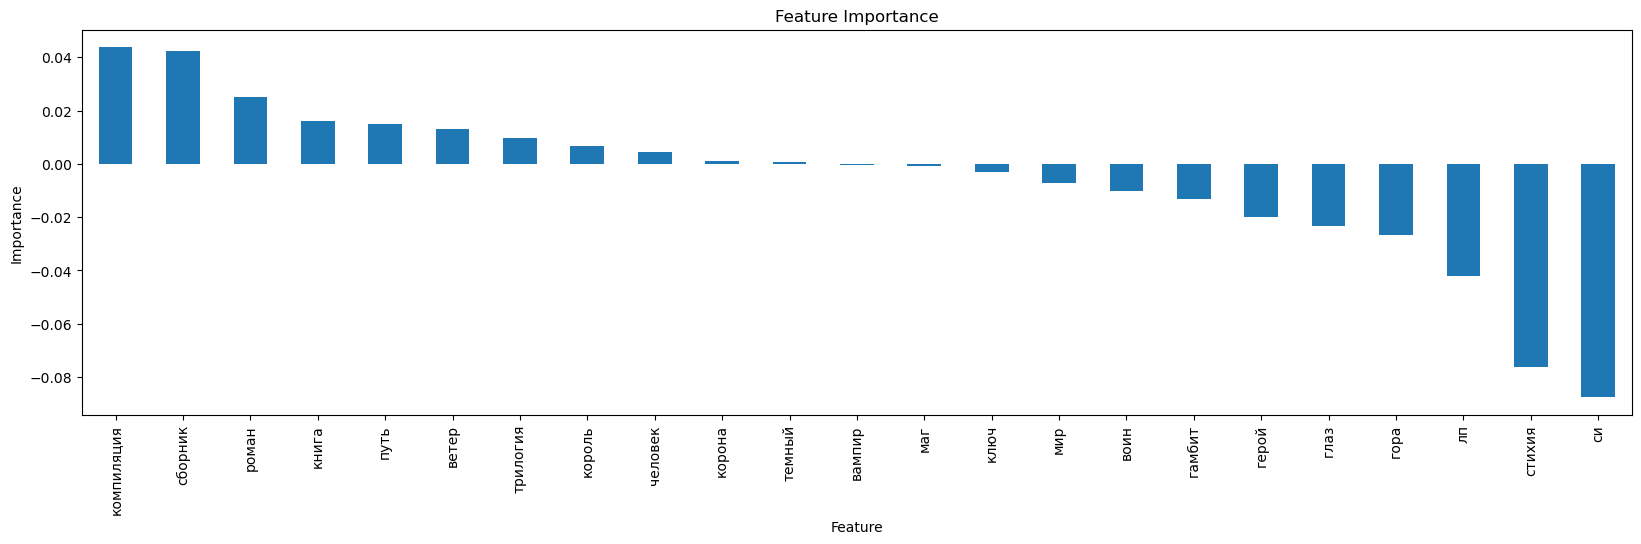

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

featureImportance = pd.DataFrame({"feature": train_data.columns[regressor.coef_!=0], 
                                  "importance": regressor.coef_[regressor.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)

featureImportance["importance"].plot(kind='bar', figsize=(20, 5));    
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

#### Предварительные выводы: 
Уже сейчас видно, что модель регрессии с обработкой текста с помощью mystem из pymystem3  на основе анализа зависимости рейтинга книги от  ее названия имеет достаточно низкую точность. Несмотря на оптимальный параметр регуляризации и относительно небольшие значения ошибок, коэффициент детерминации R2 данной модели невысок - всего 1.68%. Это указывает на то, что модель может быть не очень эффективной в предсказании рейтинга на основе названия книги.  

Применим другой метод обработки текста и посмотрим повлияет ли это на результат.

# Второй способ - обработка текста с помощью библиотеку nltk и pymorphy2 

In [63]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Olga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
!pip install pymorphy2

In [65]:
import pymorphy2 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('russian')
lemma = WordNetLemmatizer()
morph = pymorphy2.MorphAnalyzer()
word_tokenizer = nltk.WordPunctTokenizer()

Теперь создадим функцию, которая будет осуществлять предобработку текста.

In [66]:
import nltk
# nltk.download('omw-1.4')

In [67]:
# Функция для очистки данных от тегов, знаков препинаний, стоп-слов, лемматизация и токенизация

def lemmatize_and_filter(text):

    text = text.strip() 
    text = re.sub('[^A-Za-zА-Яа-я0-9]+', ' ', text) # Оставляем только буквы и цифры
        
    tokens = nltk.word_tokenize(text) # Разбиваем на токены

    tokens = [word.lower() for word in tokens] # Нижний регистр
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Убираем стоп-слова
    tokens = [lemma.lemmatize(word) for word in tokens] # Лемма
    tokens = [morph.parse(word)[0].normal_form for word in tokens]

    text = ' '.join(tokens) # Собираем в строку

    return text

Проверим работу функции на одной строке

In [68]:
data['Title'].values[2]

'Демон в беде, или Как избавиться от ведьмы?'

In [69]:
lemmatize_and_filter(data['Title'].values[2])

'демон беда избавиться ведьма'

Предобработка для всего датасета.

In [70]:
from tqdm import tqdm
tqdm.pandas()

def process_text(text):
    return lemmatize_and_filter(text)

data_preprocess = data.copy()
data_preprocess['Title'] = data['Title'].progress_apply(process_text)

# Сохранение предобработанных данных
data_preprocess.to_csv('preprocess_data_nltk.csv', index=False)


100%|██████████████████████████████████| 11874/11874 [00:10<00:00, 1161.85it/s]


In [71]:
# Загрузка из предобработанных данных
preprocess_data_nltk = pd.read_csv('preprocess_data_nltk.csv')
preprocess_data_nltk.head()

,Title,Author,Description,Raiting,Readers,Comments
0,воин,Анастасия Сиалана,Я воин! Воин первой руки великой Зиреи. Я маг ...,3.17,13,0
1,девятый уровень часть второй,Дмитрий Серебряков,"То, что казалось нереальным в начале пути, теп...",4.33,5,0
2,демон беда избавиться ведьма,"Иринья Коняева, Татьяна Серганова","Меня, ведьму, и замуж против воли? Не дождетес...",3.42,355,17
3,вагон второй класс,"Элина Литера, Анна Литера",Юная леди Илона Горналон — любимая дочь состоя...,3.75,13,0
4,лейтенант,Amazerak,Приключения в Южной Америке и возвращение в Ро...,3.50,7,0


In [72]:
preprocess_data_nltk.isnull().sum()

Title          12
Author          0
Description     0
Raiting         0
Readers         0
Comments        0
dtype: int64

In [73]:
preprocess_data_nltk.dropna(inplace=True)

In [74]:
preprocess_data_nltk.isnull().sum()

Title          0
Author         0
Description    0
Raiting        0
Readers        0
Comments       0
dtype: int64

In [75]:
preprocess_data_nltk['Title'].values[100]

'жемчужный узел'

Сохраним в Х - признак, а в у - целевую переменную.

In [76]:
X = preprocess_data_nltk['Title']
y = preprocess_data_nltk['Raiting']

In [77]:
X.shape, y.shape

((11862,), (11862,))

Разобьем выборку на train/test

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8303,), (3559,), (8303,), (3559,))

Теперь применим tf-idf преобразование для описания заголовка

In [79]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_df=0.7, min_df=5,
                              max_features=2987,
                              # stop_words='russian',
                              ngram_range=(1,2),
                              norm=None)

tfidf = tfidf_model.fit_transform(X_train).todense()
tfidf

CPU times: total: 156 ms
Wall time: 148 ms


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
tfidf_model.vocabulary_

{'дорога': 218,
 'ночь': 497,
 'загадка': 253,
 'самый': 678,
 'длинный': 204,
 'седьмой': 689,
 'мир': 442,
 'война': 110,
 'ведьмин': 75,
 'наследство': 466,
 'грань': 171,
 'ложь': 408,
 'огненный': 508,
 'буря': 64,
 'счастие': 763,
 'король': 369,
 'вид': 93,
 'госпожа': 169,
 'путь': 643,
 'крыло': 388,
 'чёрный': 873,
 'ворона': 125,
 'сердце': 693,
 'тварь': 772,
 'высокий': 147,
 'некромантка': 480,
 'величество': 78,
 'леди': 396,
 'дракон': 220,
 'выжить': 143,
 'эльф': 888,
 'лабиринт': 390,
 'магический': 421,
 'хаос': 827,
 'игра': 294,
 'книга': 341,
 'игра хаос': 297,
 'любовь': 415,
 'си': 700,
 'путешествие': 642,
 'страна': 746,
 'свет': 682,
 'тень': 775,
 'сумеречный': 758,
 'капитан': 332,
 'возвращение': 106,
 'домой': 217,
 'император': 308,
 'берег': 42,
 'судьба': 756,
 'маг': 419,
 'божественный': 53,
 'уровень': 809,
 'лицо': 404,
 'один': 512,
 'звезда': 271,
 'меч': 440,
 'дар': 179,
 'кошмар': 378,
 'имя': 311,
 'золотой': 291,
 'глаз': 157,
 'дракон си':

In [81]:
train_data = pd.DataFrame(
    tfidf_model.fit_transform(X_train).todense(),
    columns=tfidf_model.get_feature_names_out()
)
train_data

,10,12,13,14,15,18,ii,iii,of,of warcraft,...,эльфийский,эпизод,эпоха,это,эхо,яга,яд,янтарь,ярость,ястреб
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
test_data = pd.DataFrame(
    tfidf_model.transform(X_test).todense(),
    columns=tfidf_model.get_feature_names_out()
)
test_data

,10,12,13,14,15,18,ii,iii,of,of warcraft,...,эльфийский,эпизод,эпоха,это,эхо,яга,яд,янтарь,ярость,ястреб
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2.2 Построение модели регрессии

Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической. Цедевая переменная непрерывная, поэтому строим линейную регрессию.

In [83]:
from sklearn import metrics

metrics_table = pd.DataFrame({"error_type":["MAE", "MSE", "R2"]})
metrics_table.set_index("error_type")

""
error_type
MAE
MSE
R2


In [84]:
%%time

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=Lasso(), 
                         param_grid={'alpha': np.arange(0.01, 10, 0.1)}, 
                         scoring='r2',                          
                         n_jobs=-1)
grid_search.fit(train_data, y_train)

print('Best Score: ', grid_search.best_score_)
print('Best Params: ', grid_search.best_params_)

y_pred = grid_search.predict(test_data)
regressor = grid_search.best_estimator_

metrics_table['Regressor'] = [
    metrics.mean_absolute_error(y_test, y_pred),
    metrics.mean_squared_error(y_test, y_pred),
    metrics.r2_score(y_test, y_pred)
]

metrics_table

Best Score:  0.012770115254122683
Best Params:  {'alpha': 0.01}
CPU times: total: 3.75 s
Wall time: 37.3 s


,error_type,Regressor
0,MAE,0.628048
1,MSE,0.960470
2,R2,0.012434


Построим график важности признаков (топ-50 слов)

In [85]:
non_zero_coef_indices = np.where(regressor.coef_ != 0)[0]
words = train_data.columns[non_zero_coef_indices][:50]
words

Index(['гамбит', 'герой', 'другой', 'замок', 'книга', 'компиляция', 'мир',
       'ночь', 'обитель', 'оборотень', 'орк', 'первый', 'повелитель',
       'последний', 'роман', 'сборник', 'свет', 'сердце', 'си', 'стихия',
       'тень', 'трилогия', 'человек'],
      dtype='object')

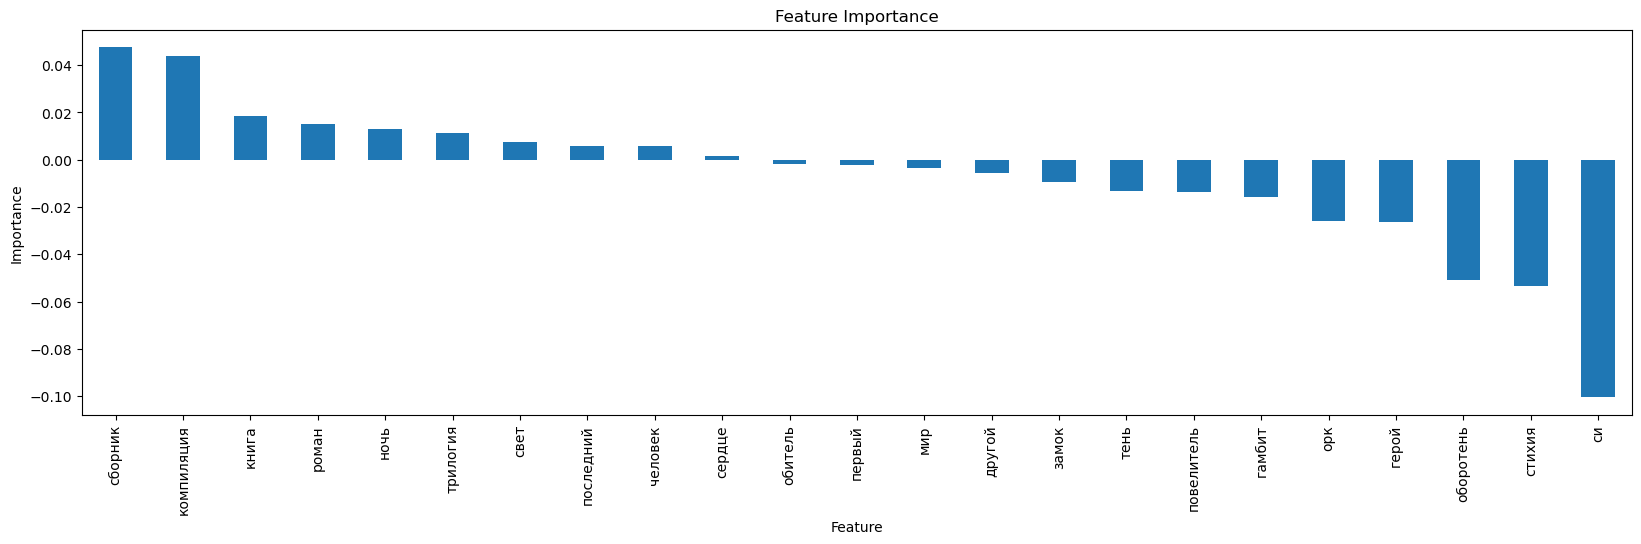

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

featureImportance = pd.DataFrame({"feature": train_data.columns[regressor.coef_!=0], 
                                  "importance": regressor.coef_[regressor.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)

featureImportance["importance"].plot(kind='bar', figsize=(20, 5));    
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Cоединим работу функций и построим разные модели

In [87]:
def load_data():
    '''
        Загружает сырые данные с новостями и количеством комментариев.
    '''
    data = pd.read_csv('books_full.csv', index_col=0)
    data['Raiting'] = data['Raiting'].fillna(0)
    return data

def preprocess_data(data):
    '''
        Делает предобратку текста новости и ее заголовка - лемматизация и отсеивание стоп-слов
    '''
    # data_preprocess_ntlk = data_preprocess_ntlk.copy()
    data_preprocess_ntlk['Title'] = data['Title'].apply(lambda text: lemmatize_and_filter(text))
    return data_preprocess_ntlk

def tf_idf(X_train, X_test, max_df=0.7, min_df=5, max_features=5000, ngram_range=(1,2)):
    '''
        Осуществляет tf-idf преобразование тренировочного и тестового наборов.
        Возвращает 2 новых датасета для тренировочного и тестового наборов.
    '''
    tfidf_model = TfidfVectorizer(max_df=max_df, min_df=min_df,
                                  max_features=max_features,
                                  # stop_words='english',
                                  ngram_range=ngram_range,
                                  norm=None)

    train_data = pd.DataFrame(
        tfidf_model.fit_transform(X_train).todense(),
        columns=tfidf_model.get_feature_names()
    )
    
    test_data = pd.DataFrame(
        tfidf_model.transform(X_test).todense(),
        columns=tfidf_model.get_feature_names()
    )
    
    return train_data, test_data

def print_feature_importance(columns, importance):
    '''
        Отображает график важности признаков.
    '''
    featureImportance = pd.DataFrame({"feature": columns, 
                                      "importance": importance})

    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)

    featureImportance["importance"].plot(kind='bar', figsize=(20, 5));    
    plt.title("Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

def calc_metrics(y_test, y_pred):
    metrics_table = pd.DataFrame({"error_type":["MAE", "MSE", "R2"]})
    metrics_table.set_index("error_type")   
    metrics_table['Regressor'] = [
        metrics.mean_absolute_error(y_test, y_pred),
        metrics.mean_squared_error(y_test, y_pred),
        metrics.r2_score(y_test, y_pred)
    ]
    print(metrics_table)
    
def regression(data, feature_column_name, target_column_name, 
               max_df, min_df, max_features, ngram_range):
    '''
        Строит модель регрессии по заданной колонке датасета.
        Отображает график важности признаков.
    '''

    X = data[feature_column_name]
    y = data[target_column_name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    train_data, test_data = tf_idf(X_train, X_test, max_df, min_df, max_features, ngram_range)
    
    grid_search = GridSearchCV(estimator=Lasso(), 
                         param_grid={'alpha': np.arange(0.01, 10, 0.1)}, 
                         scoring='r2',                          
                         n_jobs=-1)
    
    grid_search.fit(train_data, y_train)

    print('Best Score: ', grid_search.best_score_)
    print('Best Params: ', grid_search.best_params_)

    y_pred = grid_search.predict(test_data)    

    calc_metrics(y_test, y_pred)
    
    regressor = grid_search.best_estimator_
    print_feature_importance(train_data.columns[regressor.coef_!=0],
                             regressor.coef_[regressor.coef_!=0])
    
def load_data_and_process(feature_column_name, target_column_name, 
                          max_df=0.7, min_df=5, max_features=5000, ngram_range=(1,2)):
    data = load_data()
    data_prep = preprocess_data(data)
    regression(data_prep, feature_column_name, target_column_name, 
               max_df, min_df, max_features, ngram_range)

In [88]:
load_data_and_process('Title', 'Raiting')

KeyError: 'Title'

In [89]:
data = pd.read_csv('books_full.csv')  

# Проверка наличия столбца 'Title'
if 'Title' in data.columns:
    print("Столбец 'Title' существует в исходных данных.")
else:
    print("Столбец 'Title' не существует в исходных данных.")

Столбец 'Title' существует в исходных данных.


Аналогичные вичисления были сделаны для предсказания количества читателей (Readers) на основе заголовков книг при той же регрессионной модели
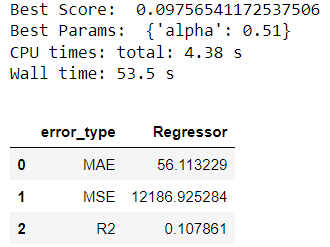

# Выводы

1. Несмотря на то, что мне не удалось запустить код для дополнительного тюнинга настроек параметров модели, подлагаю, что в данной задаче это не сильно повлияло бы на результат.

2. Сравнивая два метода обработки текста: 1) mystem из pymystem3 и 2) библиотеку nltk и pymorphy2 можно отметить следующее:

- Программная обработка библиотеки nltk и pymorphy2 более контролируема и гибка из-за использования различных библиотек для разных этапов обработки текста, в то время как mystem из pymystem3 полагается на mystem для всех задач.
- Библиотека nltk и pymorphy2 позволяет более точную настройку каждого шага обработки текста: от очистки до приведения к начальной форме слова.
- Использование mystem облегчает задачу лемматизации, но менее гибко в управлении предварительной обработкой текста в целом.
- Полученные метрики качества для обоих методов близки (см рисунок ниже). Метрики качества mystem из pymystem3 чуть лучше, однако код на библиотеке nltk и pymorphy2 считает мгновенно, в то время как расчеты с помощью mystem из pymystem3 занимают часы.

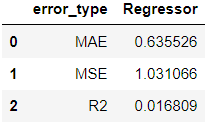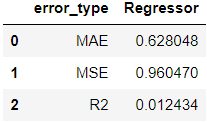

**Анализируя предсказательную силу модели при использовании предсказания оценки читателей (Raiting) на основе заголовков книг можно отметить следующее:**

Лучший показатель метрики R2 составляет около 0.017/0.013, что означает, что модель с лучшим параметром alpha при использовании Lasso регрессии может объяснить только около 1.7% /1.3% дисперсии в данных. Это довольно низкий уровень объясняемой вариации и свидетельствует о том, что модель не очень хорошо соотносится с фактическими данными.

Лучший параметр alpha для модели Lasso составляет 0.01. Это параметр регуляризации, который контролирует сложность модели. В данном случае наилучшим параметром оказался довольно низкий alpha, что может указывать на то, что модель либо недообучена, либо имеет слабую способность к обобщению.

Средняя абсолютная ошибка (MAE) равна примерно 0.635/0.628, а среднеквадратичная ошибка (MSE) равна примерно 1.031/0.960. Значения ошибок относительно невелики, что может говорить о том, что модель хорошо предсказывает данные в контексте использования Lasso регрессии.

Конечный коэффициент детерминации (R2) равен примерно 0.017/0.012, что подтверждает, что только около 1.7% /1.2% дисперсии зависимой переменной 'Raiting' может быть объяснено моделью. Это также указывает на низкую точность модели в обобщении данных.

Итак, несмотря на то, что модель хорошо справляется с предсказанием по оценкам MAE и MSE, однако нужно учитывать, что R2 является более надежным показателем качества модели, а показатели  R2 у данной  модели низкие, что говорит о низкой прогнозной точности модели.

Говоря о об оценке предсказательной силе модели при использовании предсказания количества читателей (Readers) на основе заголовков книг можно сказать, что модель показывает относительно высокую среднюю абсолютную ошибку, большую среднеквадратичную ошибку и низкий коэффициент детерминации. Это говорит о том, что модель достаточно неточно предсказывает количество читателей (Readers) на основе заголовков книг.